In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import subplot,imshow,title,gray,NullLocator
import scipy.misc as mi
import scipy.special as sp
from PIL import Image
from itertools import chain
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import model_from_json

from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')

Using Theano backend.


In [3]:
#keras.backend.backend()

In [4]:
#keras.backend.image_dim_ordering()

In [5]:
# visualizza dati
def displayData(X, t, rows=10, cols=10, img_ind=None, size =16, class_value = False):
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 16, color='b')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off')
    plt.subplots_adjust(top=1)
    plt.show()

In [6]:
def plotData(X, Y, c, npixel=28):
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (6,6))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='quadric')
    plt.show()

In [7]:
def plotAccuracy(acc_history_train, acc_history_test):
    plt.figure(figsize = (12,8))
    plt.plot(acc_history_train, marker='o', markersize=5, label='Train')
    plt.plot(acc_history_test, marker='o', markersize=5, label='Test')
    plt.legend()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.show()

In [8]:
def save_model(m,filename):
    model_json = m.to_json()
    with open(filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights(filename+".h5")
    print("Saved model to disk")

In [9]:
def load_model(filename):
    json_file = open(filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    m = model_from_json(loaded_model_json)
    # load weights into new model
    m.load_weights(filename+".h5")
    print("Loaded model from disk")
    return m

In [10]:
def load_model_weights(filename, model):
    model.load_weights(filename+".h5")
    print("Loaded weights from disk")
    return model

Fissa il numero di classi pari a 10 (corrispondenti alle cifre 0,1,...,9) e leggi i dati, suddivisi in training e test set, $(X_{train}, t_{train}), (X_{test}, t_{test})$. Le matrici $X$ rappresentano le immagini, mentre i vettori $t$ specificano le relative classi.

In [11]:
nb_classes = 10

(X_train, t_train), (X_test, t_test) = mnist.load_data()

In [12]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Visualizza la dimensione di $X_{train}$ e $X_{test}$. Le immagini rappresentate risultano indicizzate dalla prima dimensione e definite come matrici $28\times 28$. I valori nelle matrici sono interi compresi tra $0$ e $255$.


In [13]:
X_train[0,:,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Esempio: i primi 100 elementi nel training set con la relativa classe

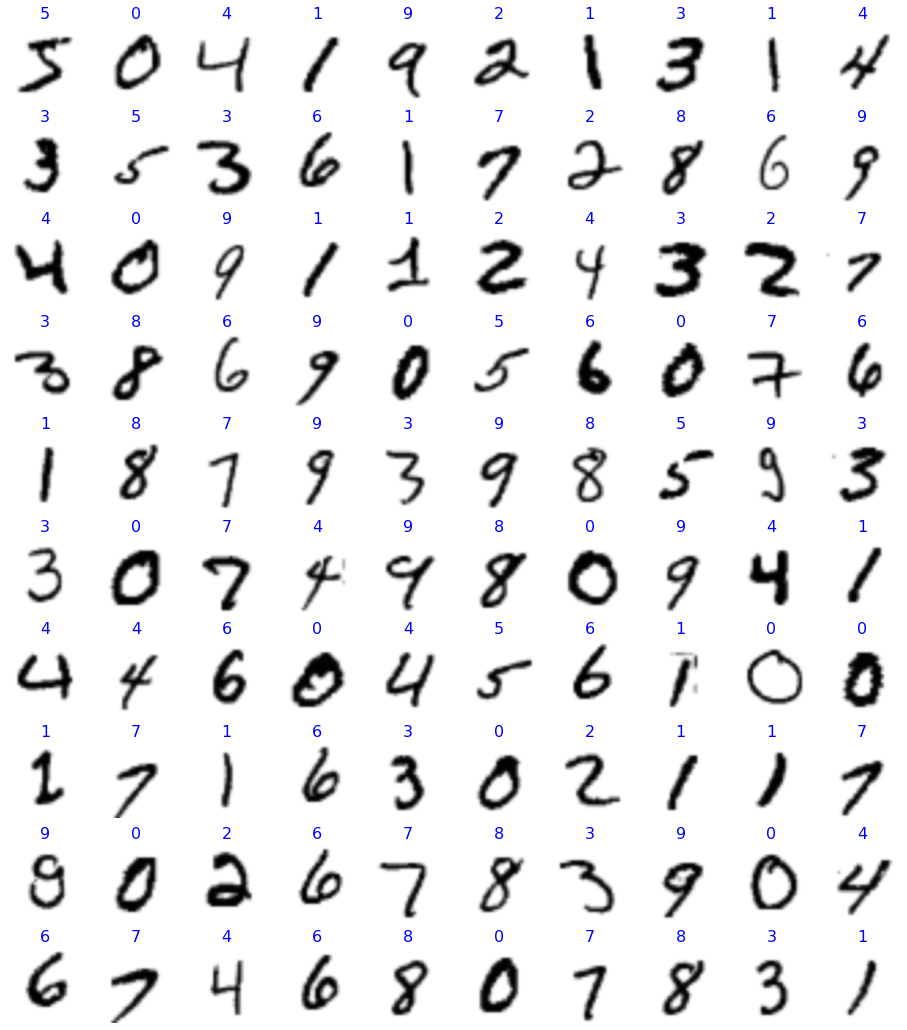

In [34]:
displayData(X_train[0:100], t_train[0:100], class_value=True)

Modifica la rappresentazione degli elementi da matrici $28\times 28$ a vettori di dimensione $784$, con elementi reali compresi tra $0$ e $1$.

In [14]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [15]:
X_train[0,:].shape

(784,)

In [16]:
t_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

Le classi vengono codificate nella forma $\textit{one-hot}$, come vettori di dimensione $10$ (il numero delle classi) con elementi pari a $0$, eccetto quello di indice pari al valore da codificare.


In [17]:
T_train = np_utils.to_categorical(t_train, nb_classes)
T_test = np_utils.to_categorical(t_test, nb_classes)

In [18]:
t_train[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [19]:
T_train[0:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Costruisci il modello (insieme delle possibili funzioni)

In [20]:
# softmax regression
model0 = Sequential()
model0.add(Dense(10, input_shape=(784,)))
model0.add(Activation('softmax'))
model0.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

In [21]:
#model0 = load_model_weights('softmax', model0)

Loaded weights from disk


Cerca la migliore funzione possibile, rispetto ai dati disponibili

In [43]:
history0 = model0.fit(X_train, T_train, batch_size=512, epochs=50, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 24us/step - loss: 1.8261 - accuracy: 0.4828 - val_loss: 1.4540 - val_accuracy: 0.7022
Epoch 2/50
60000/60000 [==============================] - 1s 16us/step - loss: 1.2757 - accuracy: 0.7422 - val_loss: 1.0945 - val_accuracy: 0.7892
Epoch 3/50
60000/60000 [==============================] - 1s 16us/step - loss: 1.0192 - accuracy: 0.7941 - val_loss: 0.9097 - val_accuracy: 0.8240
Epoch 4/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.8769 - accuracy: 0.8175 - val_loss: 0.7990 - val_accuracy: 0.8363
Epoch 5/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.7868 - accuracy: 0.8306 - val_loss: 0.7252 - val_accuracy: 0.8483
Epoch 6/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.7243 - accuracy: 0.8394 - val_loss: 0.6724 - val_accuracy: 0.8555
Epoch 7/50
60000/60000 [==============================] - 1s 13us/st

In [30]:
save_model(model0,'softmax')

Saved model to disk


Accuracy: frazione di risposte corrette

In [22]:
acc_values0 = history0.history['accuracy']
val_acc_values0 = history0.history['val_accuracy']

NameError: name 'history0' is not defined

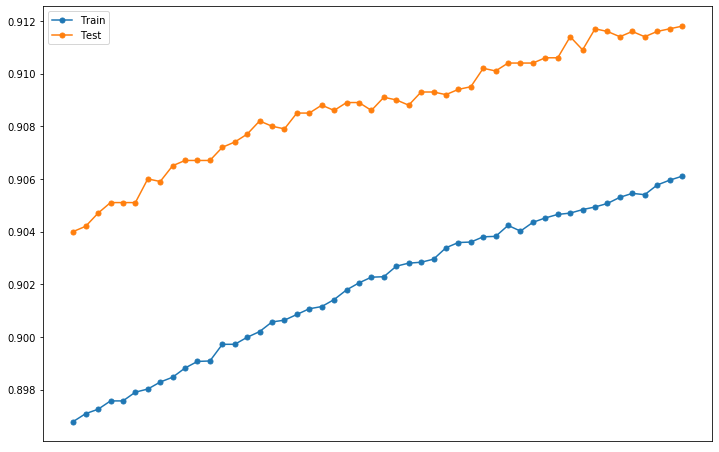

In [58]:
plotAccuracy(acc_values0, val_acc_values0)

In [23]:
predictions_train = model0.predict_classes(X_train, verbose=0)

In [24]:
confusion_matrix(t_train, predictions_train)

array([[5699,    0,   25,   15,   12,   44,   47,    8,   65,    8],
       [   0, 6521,   30,   32,    6,   38,    9,   16,   79,   11],
       [  48,   70, 5184,   95,  114,   25,  114,  107,  166,   35],
       [  28,   34,  140, 5368,    5,  250,   36,   71,  129,   70],
       [  10,   34,   41,    6, 5374,    5,   66,   16,   36,  254],
       [  92,   52,   47,  205,   72, 4558,  111,   24,  185,   75],
       [  40,   22,   61,    6,   52,   79, 5596,    9,   50,    3],
       [  38,   67,   97,   24,   78,    9,    4, 5720,   18,  210],
       [  33,  150,   78,  153,   27,  156,   54,   31, 5068,  101],
       [  46,   33,   30,   94,  207,   42,    4,  192,   53, 5248]])

Accuracy is the fraction of items well classified wrt all items

In [25]:
accuracy_score(t_train, predictions_train)

0.9056

Precision of class $C_i$: number of items of class $C_i$ well classified divided by number of items classified as belonging to $C_i$

Recall of class $C_i$: number of items of class $C_i$ well classified divided by number of items belonging to $C_i$

F-measure of class $C_i$: harmonic mean of precision and recall for class $C_i$

In [26]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision= 0.96, recall= 0.95, f-measure= 0.95
Class 1: precision= 0.97, recall= 0.95, f-measure= 0.95
Class 2: precision= 0.87, recall= 0.89, f-measure= 0.89
Class 3: precision= 0.88, recall= 0.89, f-measure= 0.89
Class 4: precision= 0.92, recall= 0.91, f-measure= 0.91
Class 5: precision= 0.84, recall= 0.86, f-measure= 0.86
Class 6: precision= 0.95, recall= 0.94, f-measure= 0.94
Class 7: precision= 0.91, recall= 0.92, f-measure= 0.92
Class 8: precision= 0.87, recall= 0.87, f-measure= 0.87
Class 9: precision= 0.88, recall= 0.88, f-measure= 0.88


In [27]:
predictions_test = model0.predict_classes(X_test, verbose=0)

In [28]:
confusion_matrix(t_test, predictions_test)

array([[ 957,    0,    1,    2,    0,    6,   10,    1,    3,    0],
       [   0, 1103,    2,    4,    1,    2,    4,    1,   18,    0],
       [  11,    8,  897,   16,   16,    1,   13,   19,   41,   10],
       [   5,    0,   19,  910,    1,   29,    3,   14,   20,    9],
       [   1,    1,    5,    1,  914,    1,   13,    1,    8,   37],
       [  12,    3,    5,   40,   11,  756,   16,    9,   32,    8],
       [  15,    3,    5,    2,   11,   15,  904,    1,    2,    0],
       [   3,   17,   26,    7,    8,    0,    0,  933,    2,   32],
       [  10,   11,    8,   22,    9,   25,   11,   13,  854,   11],
       [  11,    6,    5,   11,   42,   12,    0,   21,    7,  894]])

In [29]:
accuracy_score(t_test, predictions_test)

0.9122

In [30]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.98, recall= 0.95, f-measure= 0.95
Class 1: precision= 0.97, recall= 0.96, f-measure= 0.96
Class 2: precision= 0.87, recall= 0.89, f-measure= 0.89
Class 3: precision= 0.90, recall= 0.90, f-measure= 0.90
Class 4: precision= 0.93, recall= 0.92, f-measure= 0.92
Class 5: precision= 0.85, recall= 0.87, f-measure= 0.87
Class 6: precision= 0.94, recall= 0.94, f-measure= 0.94
Class 7: precision= 0.91, recall= 0.91, f-measure= 0.91
Class 8: precision= 0.88, recall= 0.87, f-measure= 0.87
Class 9: precision= 0.89, recall= 0.89, f-measure= 0.89


In [31]:
w0 = model0.layers[0].get_weights()
w = w0[0]

In [32]:
w0[1]

array([-0.15535061,  0.2641197 , -0.02133455, -0.12624712,  0.05548472,
        0.47375748, -0.0276521 ,  0.2597768 , -0.635576  , -0.08697653],
      dtype=float32)

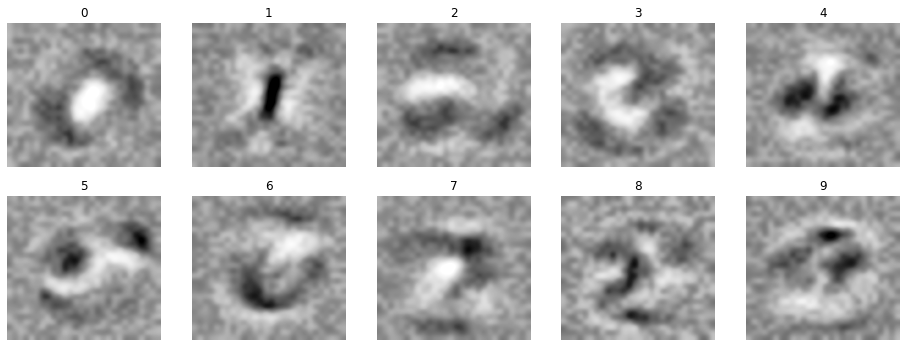

In [33]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

Elemento 6990


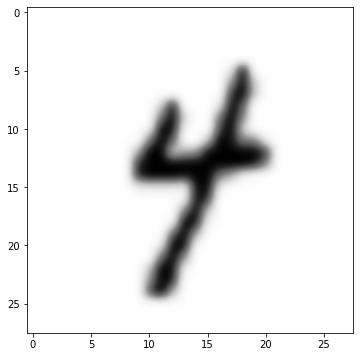

Un 4, classificato come 4


In [34]:
c = np.random.randint(0, X_test.shape[0])
p=model0.predict_classes(X_test[c:c+1,:], verbose=0)
print("Elemento "+str(c))
plotData(X_test, t_test, c)
print("Un "+str(t_test[c])+", classificato come " + str(p[0]))

In [44]:
# 3 layer NN
model1 = Sequential()
model1.add(Dense(512, input_shape=(784,)))
model1.add(Activation('sigmoid'))
#model1.add(Dropout(rate=0.2))
model1.add(Dense(10))
model1.add(Activation('softmax'))
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [36]:
#model1 = load_model_weights('3MLP', model1)

Loaded weights from disk


In [45]:
history1 = model1.fit(X_train, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.9651 - accuracy: 0.7796 - val_loss: 0.4657 - val_accuracy: 0.8884
Epoch 2/10
60000/60000 [==============================] - 3s 51us/step - loss: 0.4091 - accuracy: 0.8925 - val_loss: 0.3451 - val_accuracy: 0.9076
Epoch 3/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.3314 - accuracy: 0.9089 - val_loss: 0.2989 - val_accuracy: 0.9160
Epoch 4/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.2955 - accuracy: 0.9168 - val_loss: 0.2753 - val_accuracy: 0.9198
Epoch 5/10
60000/60000 [==============================] - 4s 74us/step - loss: 0.2719 - accuracy: 0.9227 - val_loss: 0.2568 - val_accuracy: 0.9273
Epoch 6/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.2544 - accuracy: 0.9280 - val_loss: 0.2428 - val_accuracy: 0.9300
Epoch 7/10
60000/60000 [==============================] - 3s 55us/st

In [46]:
save_model(model1,'3MLP')

Saved model to disk


In [47]:
acc_values1 = history1.history['acc']
val_acc_values1 = history1.history['val_acc']

epochs1 = range(1, len(acc_values1) + 1)

KeyError: 'acc'

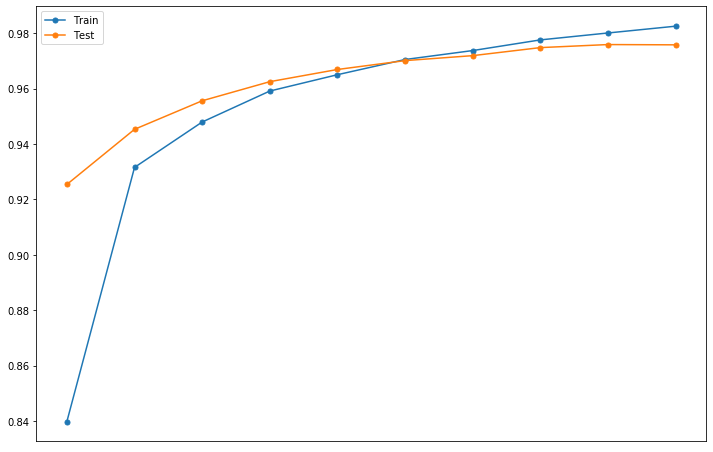

In [41]:
plotAccuracy(acc_values1, val_acc_values1)

In [48]:
predictions_train = model1.predict_classes(X_train, verbose=0)

In [49]:
confusion_matrix(t_train, predictions_train)

array([[5753,    1,   14,   10,   11,   33,   45,    8,   43,    5],
       [   1, 6598,   38,   16,   10,   19,    4,   11,   36,    9],
       [  25,   31, 5590,   44,   53,   14,   48,   59,   81,   13],
       [  16,   30,   99, 5593,    4,  178,   19,   49,  102,   41],
       [   9,   31,   25,    4, 5554,    5,   53,   11,   21,  129],
       [  35,   18,   25,   74,   30, 5074,   70,   13,   52,   30],
       [  28,   17,   23,    0,   25,   70, 5738,    2,   15,    0],
       [  12,   31,   63,   14,   46,   14,    2, 5976,   10,   97],
       [  24,  102,   38,   88,   18,   93,   37,   10, 5392,   49],
       [  21,   34,   10,   72,  126,   36,    2,  110,   35, 5503]])

In [50]:
accuracy_score(t_train, predictions_train)

0.9461833333333334

In [51]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.97, recall= 0.97, f-measure= 0.97
Class 1: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 2: precision= 0.94, recall= 0.94, f-measure= 0.94
Class 3: precision= 0.91, recall= 0.93, f-measure= 0.93
Class 4: precision= 0.95, recall= 0.95, f-measure= 0.95
Class 5: precision= 0.94, recall= 0.93, f-measure= 0.93
Class 6: precision= 0.97, recall= 0.96, f-measure= 0.96
Class 7: precision= 0.95, recall= 0.96, f-measure= 0.96
Class 8: precision= 0.92, recall= 0.93, f-measure= 0.93
Class 9: precision= 0.93, recall= 0.93, f-measure= 0.93


In [52]:
predictions_test = model1.predict_classes(X_test, verbose=0)

In [53]:
confusion_matrix(t_test, predictions_test)

array([[ 961,    0,    2,    1,    0,    6,    7,    2,    1,    0],
       [   0, 1119,    2,    2,    0,    1,    4,    2,    5,    0],
       [   7,    1,  966,    6,    6,    3,   12,    8,   20,    3],
       [   1,    1,   18,  936,    0,   25,    1,   10,   15,    3],
       [   1,    2,    6,    0,  932,    0,   11,    3,    4,   23],
       [   7,    2,    0,   13,    5,  824,   15,    4,   16,    6],
       [   9,    3,    5,    1,    7,   12,  916,    2,    3,    0],
       [   1,    8,   25,    4,    4,    1,    0,  962,    2,   21],
       [   5,    4,    6,   14,    9,   19,   10,    9,  893,    5],
       [   9,    8,    1,   11,   27,    7,    1,   14,    5,  926]])

In [54]:
accuracy_score(t_test, predictions_test)

0.9435

In [55]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 1: precision= 0.99, recall= 0.98, f-measure= 0.98
Class 2: precision= 0.94, recall= 0.94, f-measure= 0.94
Class 3: precision= 0.93, recall= 0.94, f-measure= 0.94
Class 4: precision= 0.95, recall= 0.95, f-measure= 0.95
Class 5: precision= 0.92, recall= 0.92, f-measure= 0.92
Class 6: precision= 0.96, recall= 0.95, f-measure= 0.95
Class 7: precision= 0.94, recall= 0.94, f-measure= 0.94
Class 8: precision= 0.92, recall= 0.92, f-measure= 0.92
Class 9: precision= 0.92, recall= 0.93, f-measure= 0.93


In [48]:
w0 = model1.layers[0].get_weights()[0]
w1 = model1.layers[3].get_weights()[0]
w = np.dot(w0,w1)

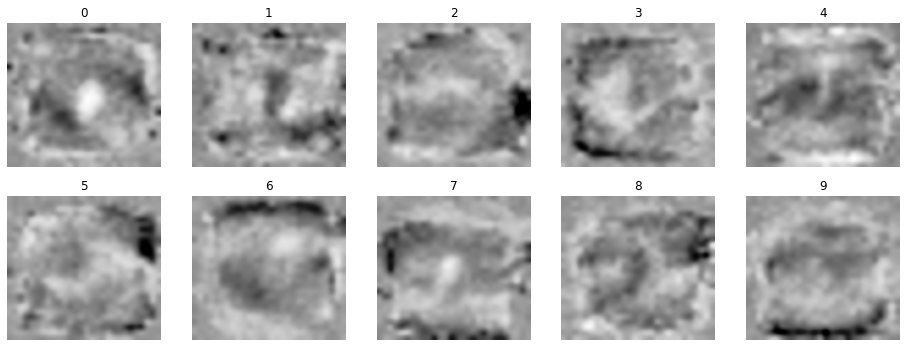

In [49]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [56]:
# 4 layer NN
model2 = Sequential()
model2.add(Dense(512, input_shape=(784,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10))
model2.add(Activation('softmax'))

In [57]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [110]:
#model2 = load_model_weights('4MLP', model2)

Loaded weights from disk


In [59]:
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [60]:
history2 = model2.fit(X_train, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.5105 - accuracy: 0.8547 - val_loss: 0.1919 - val_accuracy: 0.9420
Epoch 2/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1778 - accuracy: 0.9482 - val_loss: 0.1274 - val_accuracy: 0.9599
Epoch 3/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.1216 - accuracy: 0.9638 - val_loss: 0.0967 - val_accuracy: 0.9695
Epoch 4/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.0939 - accuracy: 0.9718 - val_loss: 0.0855 - val_accuracy: 0.9720
Epoch 5/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.0753 - accuracy: 0.9777 - val_loss: 0.0780 - val_accuracy: 0.9751
Epoch 6/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0594 - accuracy: 0.9815 - val_loss: 0.0704 - val_accuracy: 0.9770
Epoch 7/10
60000/60000 [==============================] - 7s 1

In [61]:
save_model(model2,'4MLP')

Saved model to disk


In [63]:
acc_values2 = history2.history['accuracy']
val_acc_values2 = history2.history['val_accuracy']

epochs2 = range(1, len(acc_values2) + 1)

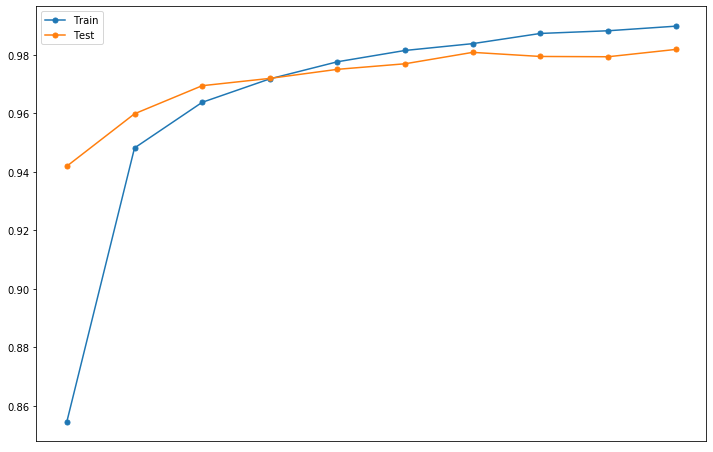

In [64]:
plotAccuracy(acc_values2, val_acc_values2)

In [65]:
predictions_train = model2.predict_classes(X_train, verbose=0)

In [66]:
confusion_matrix(t_train, predictions_train)

array([[5913,    0,    3,    1,    0,    0,    2,    0,    3,    1],
       [   0, 6723,    3,    2,    2,    0,    1,    7,    4,    0],
       [   2,    1, 5941,    3,    2,    0,    0,    3,    5,    1],
       [   0,    0,    5, 6111,    0,    2,    0,    3,    6,    4],
       [   0,    2,    1,    0, 5831,    0,    1,    3,    0,    4],
       [   0,    1,    1,   18,    0, 5391,    5,    0,    2,    3],
       [   6,    1,    1,    0,    2,    1, 5906,    0,    1,    0],
       [   0,    3,    6,    0,    1,    0,    0, 6254,    0,    1],
       [   2,    6,    2,    4,    0,    0,    2,    1, 5832,    2],
       [   1,    2,    0,    3,   13,    3,    0,    8,    3, 5916]])

In [67]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 1: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 2: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 3: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 4: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 5: precision= 0.99, recall= 1.00, f-measure= 1.00
Class 6: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 7: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 8: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 9: precision= 0.99, recall= 1.00, f-measure= 1.00


In [68]:
accuracy_score(t_train, predictions_train)

0.9969666666666667

In [69]:
predictions_test = model2.predict_classes(X_test, verbose=0)

In [70]:
confusion_matrix(t_test, predictions_test)

array([[ 971,    0,    2,    1,    0,    0,    1,    0,    3,    2],
       [   0, 1126,    3,    1,    0,    0,    2,    1,    2,    0],
       [   1,    1, 1013,    3,    1,    0,    1,    6,    6,    0],
       [   0,    0,    1,  997,    0,    0,    0,    5,    3,    4],
       [   1,    0,    2,    1,  968,    0,    1,    3,    1,    5],
       [   2,    0,    0,   16,    1,  864,    3,    1,    3,    2],
       [   4,    2,    2,    1,    4,    4,  939,    0,    2,    0],
       [   1,    3,    5,    1,    0,    0,    0, 1012,    1,    5],
       [   3,    0,    3,    8,    1,    2,    1,    2,  950,    4],
       [   2,    3,    0,    6,   10,    2,    1,    4,    2,  979]])

In [71]:
accuracy_score(t_test, predictions_test)

0.9819

In [72]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 3: precision= 0.99, recall= 0.98, f-measure= 0.98
Class 4: precision= 0.99, recall= 0.98, f-measure= 0.98
Class 5: precision= 0.97, recall= 0.98, f-measure= 0.98
Class 6: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 7: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 8: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 9: precision= 0.97, recall= 0.97, f-measure= 0.97


In [63]:
w0 = model2.layers[0].get_weights()[0]
w1 = model2.layers[3].get_weights()[0]
w2 = model2.layers[6].get_weights()[0]
w = np.dot(np.dot(w0,w1),w2)

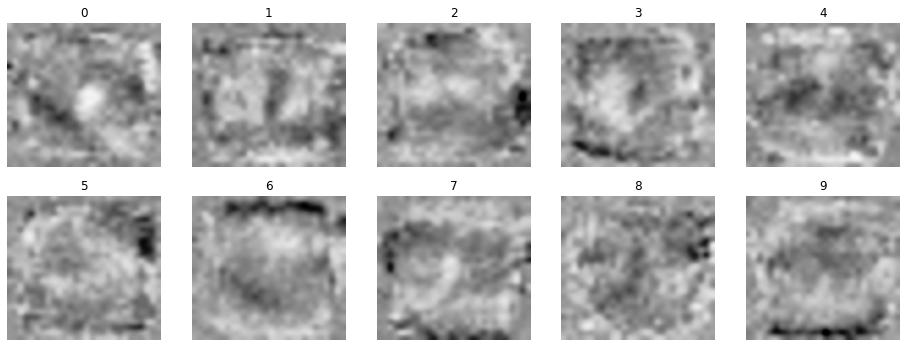

In [64]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [89]:
model3 = Sequential()
model3.add(Conv2D(30, (3, 3), input_shape=(28, 28,1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(15, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(10, activation='softmax'))

In [90]:
model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 30)        300       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 30)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 15)        4065      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 375)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)             

In [91]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
X_train_c = X_train.reshape(X_train.shape[0], 28, 28,1).astype('float32')
X_test_c = X_test.reshape(X_test.shape[0], 28, 28,1).astype('float32')

In [96]:
#model3 = load_model('CNN')

In [97]:
history3 = model3.fit(X_train_c, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test_c, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 54s 898us/step - loss: 1.0348 - accuracy: 0.6891 - val_loss: 0.2415 - val_accuracy: 0.9330
Epoch 2/10
60000/60000 [==============================] - 58s 960us/step - loss: 0.2360 - accuracy: 0.9293 - val_loss: 0.1353 - val_accuracy: 0.9594
Epoch 3/10
60000/60000 [==============================] - 54s 893us/step - loss: 0.1601 - accuracy: 0.9516 - val_loss: 0.0990 - val_accuracy: 0.9686
Epoch 4/10
60000/60000 [==============================] - 53s 888us/step - loss: 0.1240 - accuracy: 0.9621 - val_loss: 0.0731 - val_accuracy: 0.9770
Epoch 5/10
60000/60000 [==============================] - 54s 905us/step - loss: 0.1027 - accuracy: 0.9685 - val_loss: 0.0623 - val_accuracy: 0.9795
Epoch 6/10
60000/60000 [==============================] - 53s 881us/step - loss: 0.0881 - accuracy: 0.9727 - val_loss: 0.0543 - val_accuracy: 0.9818
Epoch 7/10
60000/60000 [==============================] 

In [98]:
save_model(model3,'CNN')

Saved model to disk


In [100]:
acc_values3 = history3.history['accuracy']
val_acc_values3 = history3.history['val_accuracy']

epochs3 = range(1, len(acc_values3) + 1)

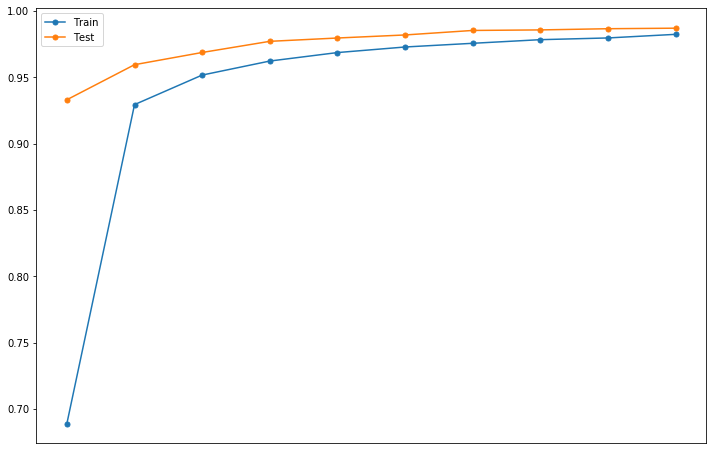

In [101]:
plotAccuracy(acc_values3, val_acc_values3)

In [102]:
predictions_train = model3.predict_classes(X_train_c, verbose=0)

In [103]:
confusion_matrix(t_train, predictions_train)

array([[5885,    0,    7,    0,    1,    1,   14,    2,    8,    5],
       [   1, 6685,   22,    3,    7,    0,    4,   12,    8,    0],
       [   1,    3, 5916,    6,    6,    0,    1,   12,    9,    4],
       [   2,    2,   46, 6007,    0,   11,    0,   15,   31,   17],
       [   0,    5,    5,    0, 5803,    0,    4,    2,    5,   18],
       [   3,    1,    3,   14,    4, 5333,   20,    1,   25,   17],
       [   4,    2,    2,    0,    7,    5, 5876,    0,   22,    0],
       [   1,    7,   32,    3,   13,    0,    0, 6187,   10,   12],
       [   4,    6,   17,    2,    9,    4,    6,    5, 5779,   19],
       [   8,    4,    2,    3,   43,    5,    0,   17,   16, 5851]])

In [104]:
accuracy_score(t_train, predictions_train)

0.9887

In [105]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 3: precision= 0.98, recall= 0.99, f-measure= 0.99
Class 4: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 5: precision= 0.98, recall= 0.99, f-measure= 0.99
Class 6: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 7: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 8: precision= 0.99, recall= 0.98, f-measure= 0.98
Class 9: precision= 0.98, recall= 0.98, f-measure= 0.98


In [106]:
predictions_test = model3.predict_classes(X_test_c, verbose=0)

In [107]:
confusion_matrix(t_test, predictions_test)

array([[ 972,    0,    1,    0,    0,    0,    2,    2,    3,    0],
       [   0, 1127,    3,    0,    0,    1,    2,    0,    2,    0],
       [   0,    1, 1025,    0,    1,    0,    0,    3,    2,    0],
       [   0,    0,    4,  993,    0,    3,    0,    4,    5,    1],
       [   0,    0,    0,    0,  975,    0,    1,    1,    1,    4],
       [   1,    0,    1,    5,    0,  879,    2,    1,    1,    2],
       [   3,    2,    0,    0,    1,    4,  945,    0,    3,    0],
       [   0,    2,    9,    2,    0,    0,    0, 1008,    3,    4],
       [   3,    0,    4,    1,    1,    0,    1,    2,  958,    4],
       [   1,    4,    1,    0,    9,    2,    0,    4,    1,  987]])

In [108]:
accuracy_score(t_test, predictions_test)

0.9869

In [109]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 3: precision= 0.98, recall= 0.99, f-measure= 0.99
Class 4: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 5: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 6: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 7: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 8: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 9: precision= 0.98, recall= 0.98, f-measure= 0.98
